# Sepsis Detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(2021)


In [2]:
df_test= pd.read_csv("test_data_without_label.csv")
df_train = pd.read_csv("training_data.csv")

## Conhecendo os dados


ID<br>
N° de Atendimento (N° do Paciente)<br>
Temperatura<br>
Pulso<br>
Respiração<br>
Pa_min (Pressão Mínima)<br>
Pa_max (Pressão Máxima)

In [3]:
df_train.head()

,id,num_atend,temperatura,pulso,respiracao,pa_min,pa_max,sepse
0,1,6066066,36.0,117.0,NaN,113.0,72.0,1
1,2,6019916,36.0,105.0,NaN,NaN,NaN,1
2,3,6000000,38.0,118.0,NaN,110.0,70.0,1
3,4,5993343,37.0,136.0,NaN,NaN,NaN,1
4,5,6001799,37.0,104.0,NaN,NaN,NaN,1


In [4]:
id = df_test.id #sera utilizado para prever depois

df_train.drop(['id', 'num_atend'], axis=1, inplace= True)

df_test.drop(['id', 'num_atend'], axis=1, inplace= True)

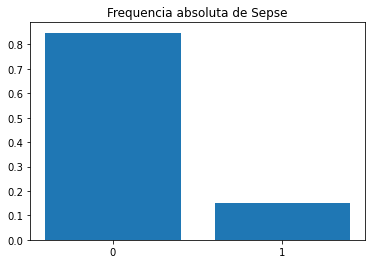

In [5]:
y = df_train.sepse.value_counts()/df_train.sepse.value_counts().sum() #frequencia absoluta
plt.bar(['0','1'],y)
plt.title('Frequencia absoluta de Sepse')
plt.show()

## Pre processamento

In [6]:
nLinhas , nColunas = df_train.shape

dupl = df_train.duplicated().sum()/nLinhas

print('Porcentagem de linhas duplicadas:', round(dupl*100,2))

Porcentagem de linhas duplicadas: 70.31


In [7]:
#Verificado a quantidade de NaN por atributo
nan_train= pd.DataFrame()
nan_train['Qtd Nan'] = df_train.isna().sum()
nan_train['Qtd Nan %'] = round(100*df_train.isna().sum()/len(df_train),2)
print('Frequencia treino:')
nan_train.head(6)

Frequencia treino:


,Qtd Nan,Qtd Nan %
temperatura,2145,12.66
pulso,2736,16.14
respiracao,13734,81.03
pa_min,8466,49.95
pa_max,8468,49.96
sepse,0,0.00


In [8]:
#Verificado a quantidade de NaN por atributo
nan_test= pd.DataFrame()
nan_test['Qtd Nan'] = df_test.isna().sum()
nan_test['Qtd Nan %'] = round(100*df_test.isna().sum()/len(df_test),2)
print('Frequencia teste:')
nan_test.head(6)

Frequencia teste:


,Qtd Nan,Qtd Nan %
temperatura,903,12.37
pulso,1183,16.21
respiracao,6174,84.58
pa_min,3864,52.93
pa_max,3865,52.95


Pelo fato de haver uma quantidade grande de dados faltantes no conjunto de treino e teste, decidimos por utilizar o KNN Imputer para atribuirmos valores aos dados faltantes. O KNN Imputer, como o nome já informa, preenche os valores ausentes usando a abordagem k-vizinhos mais próximos.

Antes de aplicarmos tal método de preenchimento, iremos verificar e tratar os atributos da base.

### Tratando o campo temperatura

In [9]:
treino = df_train.copy()
teste = df_test.copy()

In [10]:
treino.temperatura.unique()

array([  36. ,   38. ,   37. ,   35. ,   32. ,    nan,   39. ,   35.8,
          0. ,   34. ,   36.7,   35.6,  356. ,   40. ,  131. ,   36.8,
         35.1,   36.1,   35.4,   33.6,   37.6,   36.6,   35.5,   36.5,
       3602. ,   37.2,    6. ,  378. ,   36.9,  -35. ,   36.2,   36.3,
         37.7,   33. ,   85. ,  336. ,  368. ,   37.5,   35.3,   35.7,
         35.9,   36.4])

In [11]:
teste.temperatura.unique()

array([ 36. ,  37. ,   nan,  39. ,  36.6,  38. ,  36.7,  35. ,  36.3,
        37.2,  34. ,  33. ,   0. ,  37.5,  35.8,  37.7,  36.8,  35.3,
        36.1,  35.4,  35.5,  36.5,  37.6,  36.2,  35.1,  35.6,  36.9,
       378. ,  36.4, -35. ,  40. ,  35.7,  35.9,  33.6])

Alguns valores como 3602, 378, por exemplo, entende-se que foi algum erro na hora de passar os dados para a planilha, todavia, iremos atribuir nan a esses vaores.

In [12]:
inf = 9e999 #Tranforma em infinito
treino.temperatura.replace({3602:inf-inf, 378:inf-inf, 336:inf-inf, 368:inf-inf, 356:inf-inf}, inplace=True)
teste.temperatura.replace(378, np.nan, inplace=True)

In [13]:
treino.temperatura = treino.temperatura.apply(abs)
teste.temperatura = teste.temperatura.apply(abs)

Substituir temperatura nula por nan

In [14]:
treino.query('temperatura == 0')

,temperatura,pulso,respiracao,pa_min,pa_max,sepse
151,0.0,121.0,NaN,180.0,90.0,1
1155,0.0,77.0,NaN,129.0,85.0,0
2115,0.0,84.0,NaN,109.0,81.0,0
2121,0.0,98.0,NaN,145.0,91.0,0
2328,0.0,94.0,NaN,130.0,81.0,0
...,...,...,...,...,...,...
16268,0.0,87.0,18.0,90.0,57.0,0
16278,0.0,87.0,18.0,90.0,57.0,0
16462,0.0,87.0,18.0,90.0,57.0,0
16513,0.0,87.0,18.0,90.0,57.0,0


In [15]:
treino.temperatura.replace(0, np.nan, inplace=True)
teste.temperatura.replace(0, np.nan, inplace=True)

Substituir temperatura menor que 20 e maior ou igual a 45 por NaN

In [16]:
treino.query('temperatura < 20 or temperatura >= 45')

,temperatura,pulso,respiracao,pa_min,pa_max,sepse
577,131.0,106.0,NaN,NaN,NaN,1
1843,6.0,101.0,NaN,158.0,89.0,0
4451,6.0,87.0,NaN,131.0,80.0,0
7123,85.0,85.0,NaN,NaN,NaN,0
11772,85.0,85.0,NaN,NaN,NaN,0


In [17]:
treino['temperatura'].values[treino['temperatura'].values < 20] = inf-inf
treino['temperatura'].values[treino['temperatura'].values >= 45] = inf-inf

teste['temperatura'].values[teste['temperatura'].values < 20] = inf-inf
teste['temperatura'].values[teste['temperatura'].values >= 45] = inf-inf

In [18]:
treino.temperatura.unique()

array([36. , 38. , 37. , 35. , 32. ,  nan, 39. , 35.8, 34. , 36.7, 35.6,
       40. , 36.8, 35.1, 36.1, 35.4, 33.6, 37.6, 36.6, 35.5, 36.5, 37.2,
       36.9, 36.2, 36.3, 37.7, 33. , 37.5, 35.3, 35.7, 35.9, 36.4])

In [19]:
teste.temperatura.unique()

array([36. , 37. ,  nan, 39. , 36.6, 38. , 36.7, 35. , 36.3, 37.2, 34. ,
       33. , 37.5, 35.8, 37.7, 36.8, 35.3, 36.1, 35.4, 35.5, 36.5, 37.6,
       36.2, 35.1, 35.6, 36.9, 36.4, 40. , 35.7, 35.9, 33.6])

In [20]:
treino.temperatura.describe()

count    14596.000000
mean        36.187188
std          0.922318
min         32.000000
25%         36.000000
50%         36.000000
75%         36.700000
max         40.000000
Name: temperatura, dtype: float64

### Tratando o campo pulso

In [21]:
treino.pulso.unique() #batimento cardíaco

array([ 117.,  105.,  118.,  136.,  104.,   83.,   91.,   99.,   67.,
        116.,  107.,   72.,   85.,   68.,  102.,  110.,   66.,  139.,
         74.,  101.,  120.,   71.,  144.,   nan,   96.,  108.,   92.,
         98.,   94.,  100.,  114.,   78.,   87.,   97.,  106.,  111.,
        115.,  112.,   64.,   90.,  103.,   76.,  124.,   80.,  119.,
        140.,   75.,  137.,   82.,  125.,  134.,  109.,  122.,   79.,
         95.,  121.,  130.,   65.,   69.,  113.,   73.,   77.,  131.,
         88.,   81.,   93.,  126.,   84.,   56.,  128.,  170.,   60.,
         38.,  154.,  123.,  138.,  155.,   86.,  127.,   70.,   52.,
         89.,  132.,  152.,   62.,  135.,   61.,  149.,  179.,  150.,
        183.,   51.,  165.,   63.,  143.,   44.,  129.,  151.,  156.,
        158.,   55.,   59.,  153.,  174.,  186.,   42.,   40.,  145.,
         32.,  133.,   43.,  142.,   54.,  160.,   53.,   58.,   57.,
       1000.,   50.,   46.,  168.,   30.,   47.,   49.,  175.,   11.,
         10.,  166.,

In [22]:
teste.pulso.unique()

array([  93.,  107.,   90.,   69.,   71.,   nan,  104.,  103.,   99.,
         75.,   82.,   73.,   84.,   51.,   98.,   77.,   76.,   66.,
         80.,  110.,   97.,   64.,  100.,  138.,   81.,   91.,   74.,
         89.,   96.,   87.,  135.,   56.,   95.,  102.,   88.,  111.,
        101.,   86.,   68.,   78.,   83.,   94.,  128.,   85.,   62.,
        122.,  119.,  126.,   42.,   72.,   79.,   61.,   92.,   70.,
        112.,  118.,  120.,   57.,   54.,  140.,  105.,  113.,  114.,
        106.,  131.,   67.,   55.,  115.,   63.,   65.,  125.,  121.,
        155.,  144.,  130.,  123.,  109.,   10.,  142.,  116.,  169.,
        129.,  136.,  108.,  117.,   60.,  127.,  133.,   44.,   59.,
        137.,   52.,  124.,  180.,  139.,   35.,   50.,   58.,   38.,
        177.,  156.,  145.,   47.,  168.,  132., 1116.,  163.,   43.,
         53.,   46.,   49.,  178.,  165.,  134.,  149.,  704.,    0.,
         11.,  150.,  170.,  148.,  151.,  166.,  147.,  143.,  160.,
        159.,  158.,

In [23]:
treino.query('pulso >= 200') #vamos considerar maior ou igual a 200 nan

,temperatura,pulso,respiracao,pa_min,pa_max,sepse
1616,36.0,1000.0,NaN,120.0,66.0,0
6326,36.0,841.0,NaN,128.0,74.0,0
8027,36.0,200.0,NaN,NaN,NaN,0
14473,36.0,841.0,NaN,128.0,74.0,0


In [24]:
treino['pulso'].values[treino['pulso'].values >= 200] = inf-inf
teste['pulso'].values[teste['pulso'].values >= 200] = inf-inf

In [25]:
treino.query('pulso == 0') #vamos considerar valor médio arredondado

,temperatura,pulso,respiracao,pa_min,pa_max,sepse
4172,36.0,0.0,NaN,NaN,NaN,0
5523,NaN,0.0,NaN,NaN,NaN,0
5912,35.0,0.0,NaN,NaN,NaN,0
6087,35.0,0.0,NaN,NaN,NaN,0
6952,37.0,0.0,NaN,NaN,NaN,0
7058,34.0,0.0,NaN,NaN,NaN,0
7910,37.0,0.0,NaN,NaN,NaN,0
10652,38.0,0.0,NaN,NaN,NaN,0
11120,36.0,0.0,NaN,NaN,NaN,0
11156,NaN,0.0,NaN,90.0,48.0,0


In [26]:
treino.pulso.replace(0, np.nan, inplace=True)
teste.pulso.replace(0, np.nan, inplace=True)

In [27]:
treino.pulso.unique()

array([117., 105., 118., 136., 104.,  83.,  91.,  99.,  67., 116., 107.,
        72.,  85.,  68., 102., 110.,  66., 139.,  74., 101., 120.,  71.,
       144.,  nan,  96., 108.,  92.,  98.,  94., 100., 114.,  78.,  87.,
        97., 106., 111., 115., 112.,  64.,  90., 103.,  76., 124.,  80.,
       119., 140.,  75., 137.,  82., 125., 134., 109., 122.,  79.,  95.,
       121., 130.,  65.,  69., 113.,  73.,  77., 131.,  88.,  81.,  93.,
       126.,  84.,  56., 128., 170.,  60.,  38., 154., 123., 138., 155.,
        86., 127.,  70.,  52.,  89., 132., 152.,  62., 135.,  61., 149.,
       179., 150., 183.,  51., 165.,  63., 143.,  44., 129., 151., 156.,
       158.,  55.,  59., 153., 174., 186.,  42.,  40., 145.,  32., 133.,
        43., 142.,  54., 160.,  53.,  58.,  57.,  50.,  46., 168.,  30.,
        47.,  49., 175.,  11.,  10., 166., 147.,  41., 163.,  48., 177.,
       192., 157., 148., 180.,  36., 159., 162.])

In [28]:
treino.query('pulso >= 110 and sepse == 1') 

,temperatura,pulso,respiracao,pa_min,pa_max,sepse
0,36.0,117.0,NaN,113.0,72.0,1
2,38.0,118.0,NaN,110.0,70.0,1
3,37.0,136.0,NaN,NaN,NaN,1
9,37.0,116.0,NaN,111.0,70.0,1
15,37.0,110.0,NaN,NaN,NaN,1
...,...,...,...,...,...,...
10317,36.0,116.0,NaN,123.0,77.0,1
10322,NaN,131.0,39.0,82.0,37.0,1
10324,36.8,121.0,12.0,138.0,89.0,1
10325,36.8,110.0,19.0,141.0,61.0,1


### Tratando o campo respiração

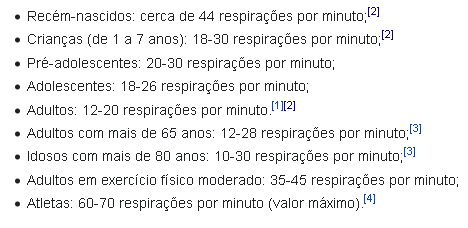

In [29]:
treino.respiracao.unique()

array([nan, 15., 33., 17., 22., 19., 16., 12., 23., 26., 27., 28., 10.,
       39., 20., 21., 24., 14., 11., 40., 25., 18., 13.,  0., 29.])

In [30]:
treino.query('respiracao == 0') #zero igual a nan

,temperatura,pulso,respiracao,pa_min,pa_max,sepse
5308,36.7,103.0,0.0,121.0,70.0,0
13783,36.7,103.0,0.0,121.0,70.0,0


In [31]:
treino.respiracao.replace(0, np.nan, inplace=True)
teste.respiracao.replace(0, np.nan, inplace=True)

### Tratando o campo pressão minima e máxima

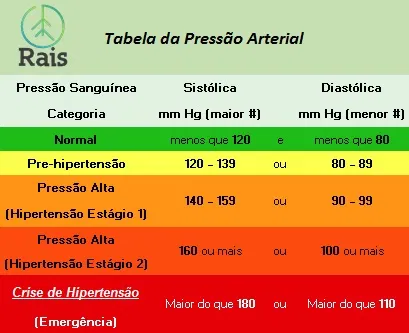

Através dos valores, entendemos que pressão mínima da base é a sistólica e pressão máxima, Diastólica.

In [32]:
treino.pa_min.unique()

array([ 113.,   nan,  110.,  153.,  111.,  126.,  107.,  185.,  127.,
        133.,   97.,  191.,  130.,  170.,  143.,  147.,  120.,   90.,
        122.,  138.,  152.,  137.,  142.,  119.,  125.,  115.,  204.,
        150.,  128.,  117.,  118.,  160.,  100.,  155.,  149.,  114.,
        159.,  123.,  108.,  102.,  145.,  180.,  136.,  140.,  169.,
        178.,  144.,  103.,  105.,  109.,   88.,  134.,  101.,  164.,
        167.,   89.,  135.,  132.,  148.,  139.,  131.,   94.,  200.,
        182.,   86.,   81.,  146.,  186.,  121.,  106.,   93.,  112.,
        189.,  154.,  187.,  163.,  129.,  124.,  141.,  116.,   10.,
         98.,  156.,  166.,  151.,  175.,   92.,   79.,  104.,  212.,
         85.,  220.,   91.,  209.,   95.,  165.,  157.,  161.,  171.,
        158.,   82.,   74.,  168.,  173.,   96.,  179.,  162.,  172.,
         99.,   75.,  219.,  184.,  190.,  197.,  230.,  177.,  202.,
        174.,   15.,  224.,  208.,  236.,   40.,  198.,  199.,  203.,
         12.,  215.,

In [33]:
treino.query('pa_min == 0') #zero igual a nan

,temperatura,pulso,respiracao,pa_min,pa_max,sepse
11982,NaN,63.0,15.0,0.0,0.0,0
13753,NaN,63.0,15.0,0.0,0.0,0


In [34]:
treino.pa_min.replace(0, np.nan, inplace=True)
teste.pa_min.replace(0, np.nan, inplace=True)

In [35]:
treino.query('pa_min > 220') #recebe nan

,temperatura,pulso,respiracao,pa_min,pa_max,sepse
1566,36.0,100.0,NaN,230.0,120.0,0
1765,35.0,85.0,NaN,224.0,101.0,0
2452,NaN,175.0,NaN,236.0,116.0,0
3083,36.0,75.0,NaN,230.0,100.0,0
3153,36.0,84.0,NaN,230.0,112.0,0
4751,35.0,68.0,NaN,225.0,97.0,0
4987,36.0,83.0,NaN,233.0,105.0,0
5273,36.0,80.0,NaN,231.0,140.0,0
7658,35.0,90.0,NaN,222.0,118.0,0
8749,NaN,85.0,NaN,242.0,122.0,0


In [36]:
treino['pa_min'].values[treino['pa_min'].values > 220] = inf-inf
teste['pa_min'].values[teste['pa_min'].values > 220] = inf-inf

In [37]:
treino.query('pa_min < 80')

,temperatura,pulso,respiracao,pa_min,pa_max,sepse
442,37.0,125.0,NaN,10.0,75.0,1
519,36.0,106.0,NaN,79.0,52.0,1
884,37.0,117.0,NaN,74.0,56.0,1
1118,NaN,51.0,NaN,75.0,52.0,0
1706,36.0,71.0,NaN,15.0,89.0,0
2474,35.0,74.0,NaN,40.0,69.0,0
2739,36.0,95.0,NaN,12.0,69.0,0
3108,38.0,85.0,NaN,11.0,75.0,0
3270,35.0,84.0,NaN,11.0,79.0,0
3292,35.0,92.0,NaN,15.0,84.0,0


In [38]:
treino.pa_max.unique()

array([ 72.,  nan,  70., 118.,  56.,  76.,  64.,  75.,  51.,  92., 107.,
        87., 112.,  99., 114.,  59.,  46.,  67.,  83.,  82.,  84.,  96.,
        78.,  69.,  66., 123.,  68.,  79.,  60., 102.,  80.,  54.,  90.,
        73.,  74.,  65.,  77.,  91., 111.,  62.,  93.,  71., 110.,  63.,
        53.,  58.,  61.,  81.,  85.,  48.,  89.,  41.,  57., 100.,  55.,
        86.,  50.,  88.,  47.,  52.,  97., 140., 101., 126.,  94., 108.,
       109., 124.,  95., 106., 113., 115.,  37.,  45., 116.,  98.,  11.,
       103., 117., 120., 119., 104.,  20.,  49., 130., 131., 105.,  10.,
         8., 121., 133., 150., 135.,  43.,   0., 969., 122.,  44., 883.,
       704.])

In [39]:
treino.query('pa_max == 0') #zero igual a nan

,temperatura,pulso,respiracao,pa_min,pa_max,sepse
7847,36.0,94.0,NaN,121.0,0.0,0
10827,36.0,94.0,NaN,121.0,0.0,0
11982,NaN,63.0,15.0,NaN,0.0,0
13753,NaN,63.0,15.0,NaN,0.0,0


In [40]:
treino.pa_max.replace(0, np.nan, inplace=True)
teste.pa_max.replace(0, np.nan, inplace=True)

In [41]:
treino.query('pa_max > 180') #recebe nan

,temperatura,pulso,respiracao,pa_min,pa_max,sepse
8605,36.0,100.0,NaN,145.0,969.0,0
14740,NaN,92.0,NaN,153.0,883.0,0
15696,NaN,126.0,NaN,197.0,704.0,0


In [42]:
treino['pa_max'].values[treino['pa_max'].values > 180] = inf-inf
teste['pa_max'].values[teste['pa_max'].values > 180] = inf-inf

Também substituímos as variáveis contínuas da pressão por dados categóricos, distribuídos nas faixas da imagem  que trouxemos logo no início, porém os resultados foram piores.

Medidas para os casos de sepse positiva

In [43]:
sepse1 = treino.query('sepse == 1')

In [44]:
sepse1.describe()

,temperatura,pulso,respiracao,pa_min,pa_max,sepse
count,2336.000000,2406.000000,1046.000000,1692.000000,1691.000000,2575.0
mean,36.335916,99.599751,20.817400,125.989953,67.604376,1.0
std,1.136880,20.942447,5.250119,23.701485,16.540542,0.0
min,32.000000,32.000000,10.000000,10.000000,11.000000,1.0
25%,35.100000,84.000000,18.000000,111.000000,53.000000,1.0
50%,36.100000,101.000000,19.000000,124.000000,67.000000,1.0
75%,37.000000,112.000000,22.000000,143.000000,79.000000,1.0
max,40.000000,186.000000,40.000000,220.000000,140.000000,1.0


## Utilizando o KNN imputer para o preenchimento dos dados nan

In [45]:
#Divide the features into Independent and Dependent Variable
X = treino.drop('sepse' , axis =1)
y = treino['sepse']
y_completo = y.copy()

In [46]:
# knn imputation treino
from numpy import isnan
from sklearn.impute import KNNImputer

# define imputer
imputer = KNNImputer()
# fit on the dataset
imputer.fit(X)
# transform the dataset
Xtrans = imputer.transform(X)

In [47]:
Xtrans

array([[ 36. , 117. ,  18. , 113. ,  72. ],
       [ 36. , 105. ,  19. , 134.8,  85.4],
       [ 38. , 118. ,  18. , 110. ,  70. ],
       ...,
       [ 35.4,  69. ,  23.4, 149. ,  93. ],
       [ 35.2,  95. ,  19. , 136. ,  82. ],
       [ 37. ,  88. ,  20. , 141.8,  63.4]])

In [48]:
#vontando treino para o tipo dataframe
basey = pd.DataFrame()
basey['sepse'] = y
basex = pd.DataFrame(Xtrans, columns=X.columns)

In [49]:
#Juntando Treino pós imputação
treino_full = pd.concat([basex, basey], axis=1)
treino_completo = treino_full

In [50]:
#Verificado a quantidade de NaN por atributo
nan_train= pd.DataFrame()
nan_train['Qtd Nan'] = treino_full.isna().sum()
nan_train['Qtd Nan %'] = round(100*treino_full.isna().sum()/len(treino_full),2)
print('Frequencia treino:')
nan_train.head(6)

Frequencia treino:


,Qtd Nan,Qtd Nan %
temperatura,0,0.0
pulso,0,0.0
respiracao,0,0.0
pa_min,0,0.0
pa_max,0,0.0
sepse,0,0.0


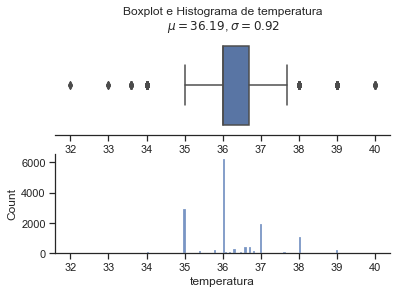

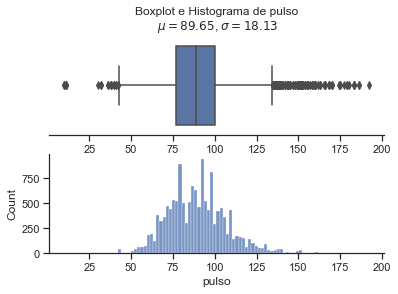

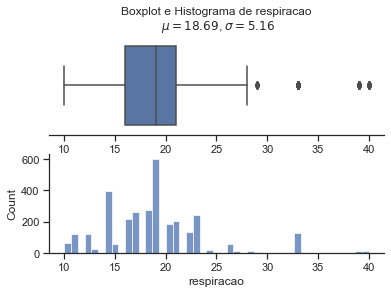

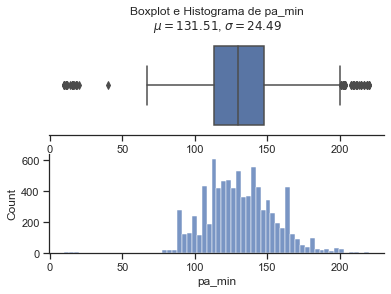

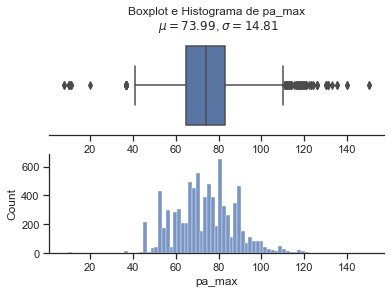

In [51]:
for i in treino_full.drop('sepse', axis = 1).columns:

  sns.set(style="ticks")

  x = treino[i]
  coluna = i
  mu = round(x.mean(),2) # mean of distribution
  sigma = round(x.std(),2)  # standard deviation of distribution

  f, (ax_box, ax_hist) = plt.subplots(2)

  sns.boxplot(x=x, ax=ax_box)
  sns.histplot(x=x, ax=ax_hist)

  ax_box.set(yticks=[])
  sns.despine(ax=ax_hist)
  sns.despine(ax=ax_box, left=True)
  ax_box.set_title('Boxplot e Histograma de {}\n $\mu={}$, $\sigma={}$'.format(coluna, mu,sigma))

plt.show()

Pelo fato de termos obervados valores positivos e negativos para a sepse em relação às variáveis pulso, pa_min e pa_max nos valores apresentados como outlier, mas olhando a base antes do preenchiemnto dos nan, decidimos por não aumentar mais os valores a serem considerados como nan. Todavia, fica um ponto de atenção a ser tratado logo na coleta dos dados, pois nesses casos, não da para saber se de fato ocorreu o valor apresentado ou se também foi algum tipo de erro.

In [52]:
treino.query('pulso >= 130 and sepse == 0').head(10) #185 linhas com sepse == 1 e 209 com sepse == 0

,temperatura,pulso,respiracao,pa_min,pa_max,sepse
1287,36.0,135.0,NaN,NaN,NaN,0
1292,38.0,130.0,NaN,126.0,98.0,0
1303,36.0,144.0,NaN,NaN,NaN,0
1320,NaN,131.0,NaN,NaN,NaN,0
1358,35.0,133.0,NaN,NaN,NaN,0
1480,39.0,140.0,NaN,NaN,NaN,0
1500,35.0,154.0,NaN,200.0,100.0,0
1644,36.0,130.0,NaN,123.0,77.0,0
1679,36.0,138.0,NaN,NaN,NaN,0
1695,36.0,152.0,NaN,202.0,119.0,0


In [53]:
treino.query('pa_max >= 110 and sepse == 1').head(10) #24 com sepse == 1 e 108 sepse == 0

,temperatura,pulso,respiracao,pa_min,pa_max,sepse
8,35.0,67.0,NaN,153.0,118.0,1
14,NaN,102.0,NaN,185.0,118.0,1
28,36.0,104.0,NaN,170.0,112.0,1
32,35.0,108.0,NaN,147.0,114.0,1
76,35.0,90.0,NaN,204.0,123.0,1
149,35.0,74.0,NaN,153.0,114.0,1
163,39.0,75.0,NaN,178.0,111.0,1
204,35.0,84.0,NaN,170.0,110.0,1
276,NaN,107.0,NaN,182.0,114.0,1
301,37.0,115.0,NaN,186.0,112.0,1


In [54]:
treino.query('pulso <= 40 and sepse == 1').head(10) #10 sepse == 0 e 4 com sepse == 1

,temperatura,pulso,respiracao,pa_min,pa_max,sepse
258,35.0,38.0,NaN,155.0,78.0,1
941,35.0,40.0,NaN,NaN,NaN,1
965,35.0,32.0,NaN,NaN,NaN,1
8931,35.0,38.0,NaN,155.0,78.0,1


In [55]:
treino.query('pa_max < 40 and sepse == 1') #16 com sepse == 1 e 14 com sepse == 0

,temperatura,pulso,respiracao,pa_min,pa_max,sepse
837,NaN,131.0,39.0,82.0,37.0,1
1054,35.0,56.0,NaN,140.0,11.0,1
9004,NaN,131.0,39.0,82.0,37.0,1
9162,NaN,131.0,39.0,82.0,37.0,1
9205,NaN,131.0,39.0,82.0,37.0,1
9478,NaN,131.0,39.0,82.0,37.0,1
9520,NaN,131.0,39.0,82.0,37.0,1
9547,NaN,131.0,39.0,82.0,37.0,1
9772,NaN,131.0,39.0,82.0,37.0,1
9790,NaN,131.0,39.0,82.0,37.0,1


## Treino e teste

In [56]:
X = treino_full.drop('sepse' , axis =1)
y = treino_full['sepse']
X = X.to_numpy()
y = y.to_numpy()

In [57]:
# Importa bibliotecas
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state=42)

In [58]:
from sklearn.preprocessing import MinMaxScaler

MinMax = MinMaxScaler()

X_train = MinMax .fit_transform(X_train)
X_test = MinMax .transform(X_test)

## Regressão Logística

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

precisao = []
f1 = []
acuracia = []

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

for train_index, test_index in cv.split(X, y):
  x_train, x_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  model = LogisticRegression()
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test)

  precisao.append(precision_score(y_test, y_pred, average="macro"))
  f1.append(f1_score(y_test, y_pred, average="macro"))
  acuracia.append(balanced_accuracy_score(y_test, y_pred))
print('Acuracia média: ', np.mean(acuracia))
print('Precisão média: ', np.mean(precisao))
print('F1 médio: ', np.mean(f1))

Acuracia média:  0.5253959907920419
Precisão média:  0.6583524278348761
F1 médio:  0.5141035935161595


## Naive Bayes

In [60]:
from sklearn.naive_bayes import GaussianNB           

precisao = []
f1 = []
acuracia = []

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

for train_index, test_index in cv.split(X, y):
  x_train, x_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  model = GaussianNB()
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test)

  precisao.append(precision_score(y_test, y_pred, average="macro"))
  f1.append(f1_score(y_test, y_pred, average="macro"))
  acuracia.append(balanced_accuracy_score(y_test, y_pred))
print('Acuracia média: ', np.mean(acuracia))
print('Precisão média: ', np.mean(precisao))
print('F1 médio: ', np.mean(f1))

Acuracia média:  0.5833666999524743
Precisão média:  0.6585220325685529
F1 médio:  0.5997136272100843


## Random forest

In [61]:
from sklearn.ensemble import RandomForestClassifier

precisao = []
f1 = []
acuracia = []

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

for train_index, test_index in cv.split(X, y):
  x_train, x_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  model = RandomForestClassifier()
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test)

  precisao.append(precision_score(y_test, y_pred, average="macro"))
  f1.append(f1_score(y_test, y_pred, average="macro"))
  acuracia.append(balanced_accuracy_score(y_test, y_pred))
print('Acuracia média: ', np.mean(acuracia))
print('Precisão média: ', np.mean(precisao))
print('F1 médio: ', np.mean(f1))

Acuracia média:  0.6619836318079815
Precisão média:  0.7124411235618712
F1 médio:  0.6808835483339327


## KNN

In [62]:
from sklearn.neighbors import KNeighborsClassifier

precisao = []
f1 = []
acuracia = []

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

for train_index, test_index in cv.split(X, y):
  x_train, x_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  model = KNeighborsClassifier(n_neighbors= 20)
  model.fit(x_train,y_train)
  y_pred = model.predict(x_test)

  precisao.append(precision_score(y_test, y_pred, average="macro"))
  f1.append(f1_score(y_test, y_pred, average="macro"))
  acuracia.append(balanced_accuracy_score(y_test, y_pred))
print('Acuracia média: ', np.mean(acuracia))
print('Precisão média: ', np.mean(precisao))
print('F1 médio: ', np.mean(f1))

Acuracia média:  0.6175641714353243
Precisão média:  0.7199765038567818
F1 médio:  0.6417681902289986


Preenchendo os NAs do teste com o KNNImputer

In [63]:
# knn imputation teste
from numpy import isnan
from sklearn.impute import KNNImputer

imputer = KNNImputer()
# fit on the dataset
imputer.fit(teste)
# transform the dataset
Xtransteste = imputer.transform(teste)

#Teste pós imputação
teste = pd.DataFrame(Xtransteste, columns = teste.columns)

## Submetendo os resultados no Kaggle usando o modelo de classificação: Floresta Aleatória

In [64]:
RF_model = RandomForestClassifier()
X = treino_completo.drop('sepse', axis =1)
y = y_completo

RF_model.fit(X,y)

y_pred = RF_model.predict(teste) 
y_pred = np.array(y_pred, dtype = int)
prediction = pd.DataFrame()
prediction['id'] = id
prediction['sepse'] = y_pred

prediction['sepse'].value_counts()

0    6718
1     582
Name: sepse, dtype: int64

In [65]:
prediction.to_csv('RFsimples.csv', index = False)

0.91411 Kaggle foi nossa melhor pontuação

In [66]:
prediction.head(10)

,id,sepse
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


## Submetendo os resultados no Kaggle usando o modelo de classificação: KNN

In [67]:
KNN_model = KNeighborsClassifier(n_neighbors= 20)
X = treino_completo.drop('sepse', axis =1)
y = y_completo

KNN_model.fit(X,y)

y_pred = KNN_model.predict(teste) 
y_pred = np.array(y_pred, dtype = int)
prediction = pd.DataFrame()
prediction['id'] = id
prediction['sepse'] = y_pred

prediction['sepse'].value_counts()

0    6715
1     585
Name: sepse, dtype: int64

In [68]:
prediction.to_csv('KNN20.csv', index = False)